# Wind Energy Forecasting model based on LSTM neural networks

We aim to develop an efficient and sufficiently accurate time series model, capable enough to forecast the active power output of the wind farm.

The dataset chosen is from a wind farm in Turkey. The systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals.

We begin by importing the necessary python packages for the project

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import os

We import the dataset. We have a look at the contents by using the .head() statement.

In [2]:
df_check = pd.read_csv(r"C:\Users\asuto\Desktop\Assignments\windenergydata.csv")
df_check.head()

,Date/Time,DC Power (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047790,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


Considering the fact that the project is based on a time series dataframe, we import the dataset after following the required transformations.

In [3]:
df = pd.read_csv(r"C:\Users\asuto\Desktop\Assignments\windenergydata.csv",index_col='Date/Time',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DC Power (kW)                  50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


We check if we have any missing data values in the dataset

In [4]:
np.isnan(df).sum()

DC Power (kW)                    0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

This is followed by observing the statistical information of the dataset.

In [5]:
df.describe()

,DC Power (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507569,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


We now plot the dataset's features using Matplotlib.

The below plot shows the variation of the data through out the year, respectively.

DC Power (kW)                    0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


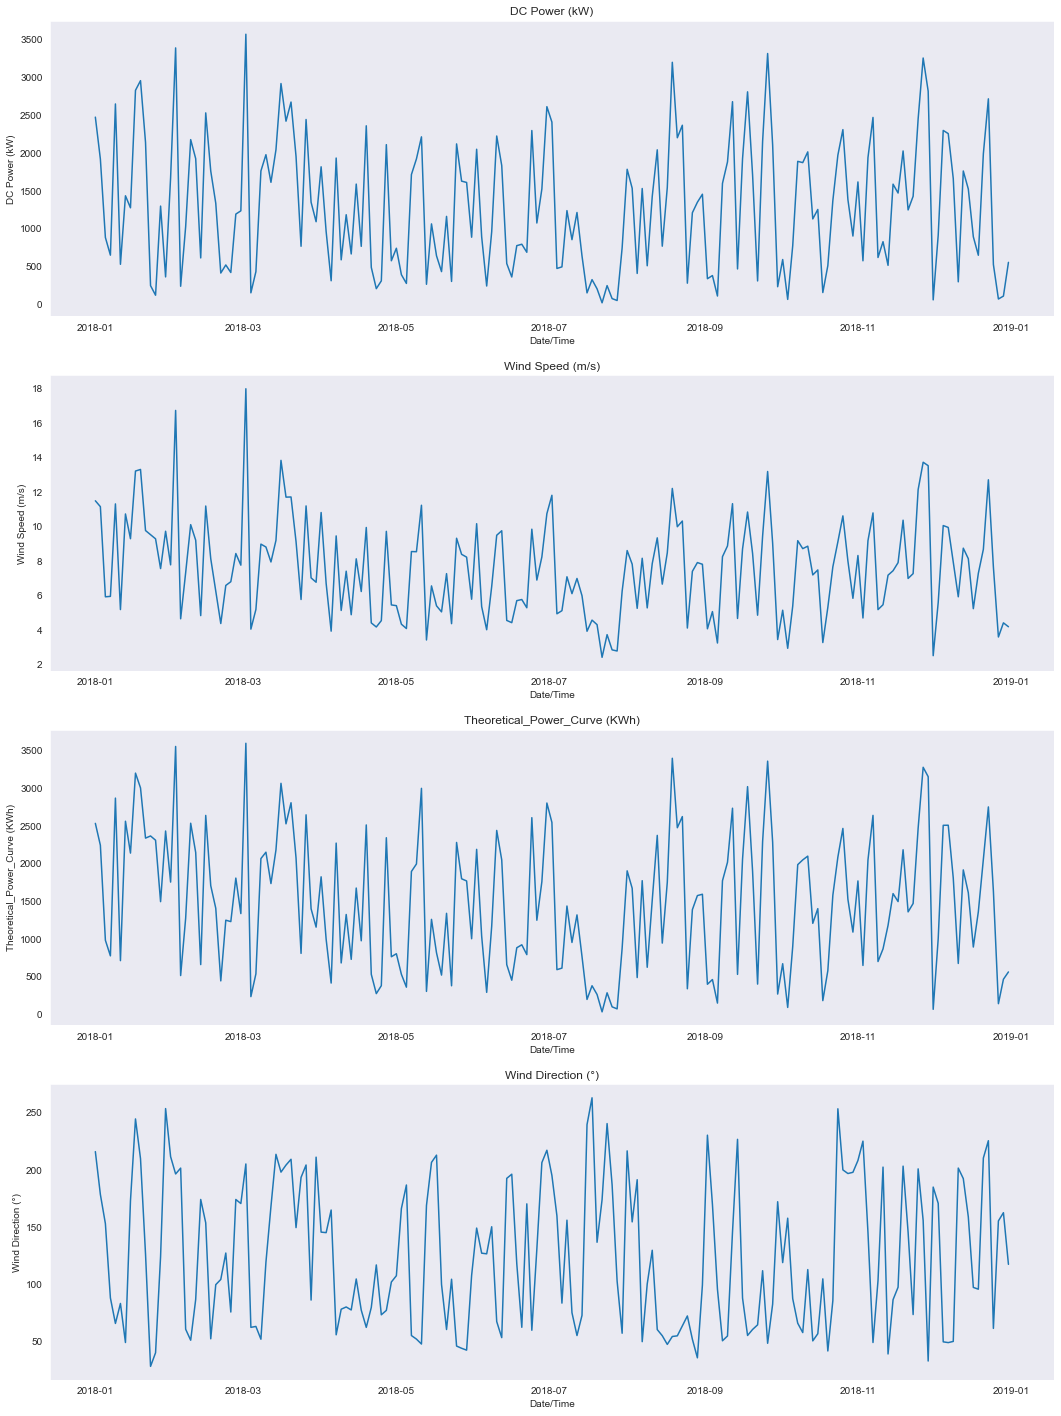

In [19]:
df2 = df.resample('2D').mean()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

for i in range(df.shape[1]):
    name = df.columns[i]
    df2[name] = imp.fit_transform(np.array(df2[name]).reshape(df2.shape[0],-1))
    
print(np.isnan(df2).sum())
#df3.head(20)

_,_=plt.subplots(figsize=(18,25))
sns.set_style('dark')
for i in range(df.shape[1]):
    name=df.columns[i]
    plt.subplot(df2.shape[1],1,i+1)
    plt.title(name)
    sns.lineplot(data=df2[name])
plt.show()

The below plot shows the variation of the power output with the wind speed. 

We see that majority of the output power is around the range of 500 to 1000 are concentrated at a wind speed or around 2 to 6m/s

<AxesSubplot:xlabel='DC Power (kW)', ylabel='Wind Speed (m/s)'>

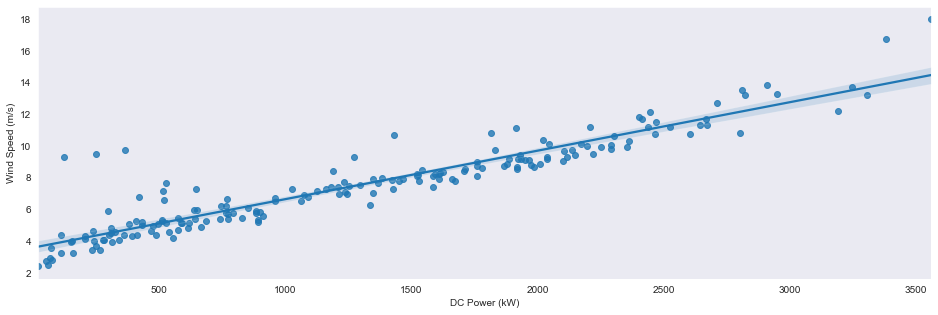

In [20]:
plt.figure(figsize=(16,5))
sns.regplot(y=df2['Wind Speed (m/s)'],x=df2['DC Power (kW)'])

D:\Program Files\anaconda3\envs\particle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Wind Speed (m/s)', ylabel='Density'>

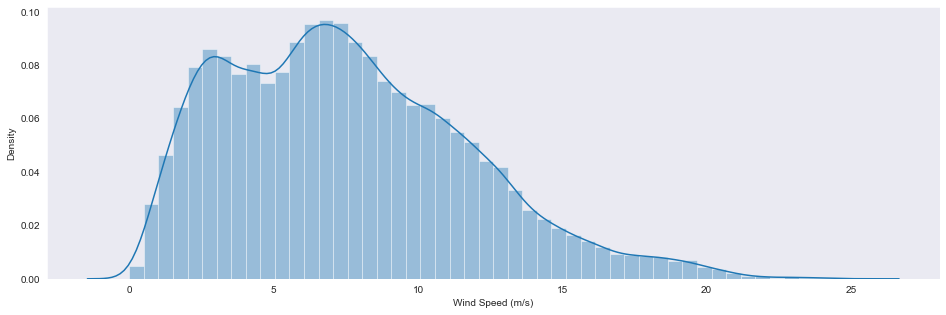

In [16]:
plt.figure(figsize=(16,5))
sns.distplot(a=df['Wind Speed (m/s)'], kde = True)

D:\Program Files\anaconda3\envs\particle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Wind Direction (°)', ylabel='Density'>

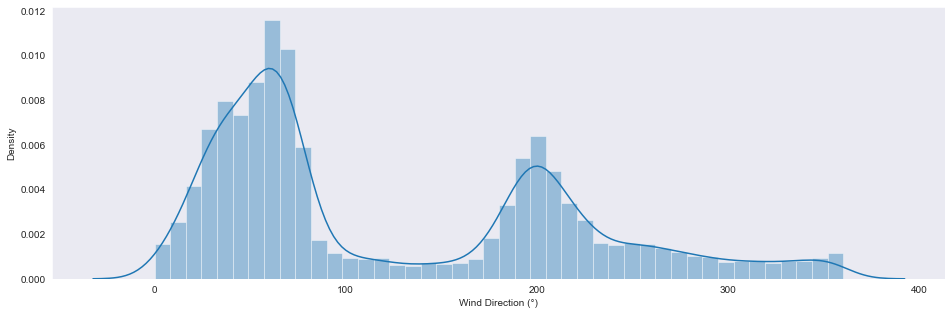

In [18]:
plt.figure(figsize=(16,5))
sns.distplot(a=df['Wind Direction (°)'], kde = True)

## Preparing the data and constructing the model

Feature scaling/data normalization is the method used to standardize the range of features of data. Since, the range of values of data may vary widely, it becomes a necessary step in data preprocessing while using machine learning algorithms

In [22]:
df3 = df.resample('30T').mean()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

for i in range(df.shape[1]):
    name = df.columns[i]
    df3[name] = imp.fit_transform(np.array(df3[name]).reshape(df3.shape[0],-1))

sca = StandardScaler()

for i in range(df.shape[1]):
    name = df.columns[i]
    df3[name] = sca.fit_transform(np.array(df3[name]).reshape(df3.shape[0],-1))

We split the dataset into training and testing data for the purpose of construction of the model."

In [24]:
traindat = df3.loc[:'2018-12-30 23:00:00']
testdat = df3.loc['2018-12-30 23:00:00':]

The below step is one of the most critical steps in the script. Here, we generate several chunks of data, in the form of arrays, containing a set of input data and a corresponding output target data.

However, in our case, the input is a set of time series data and the output target data is a consecutive time step data.

In [26]:
def chunk(data,a):
    x,y=[],[]
    for i in range(data.shape[0]-a):
        x.append(data.iloc[i:i+a,1:])
        y.append(data.iloc[i+a,0])
    return(np.array(x),np.array(y))


train_ip,train_tar=chunk(traindat,7)
test_ip,test_tar=chunk(testdat,7)